In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gt = pd.read_csv("https://raw.githubusercontent.com/namnv78/similaritymatching/tuha5/facebook_matching/src/df_train.csv")
pred = pd.read_csv("/content/drive/MyDrive/Viettel DTalent/ViettelTalentsPhase2/Phan Nhật Minh/toy_ds_result_yolo.csv")

In [3]:
gt_matches = []
for idx, row in gt.iterrows():
    gt_matches.append([row["query_id"], row["reference_id"]])

In [4]:
predictions = []
for idx, row in pred.iterrows():
    predictions.append([row["query_id"], row["reference_id_x"], row['score']])

In [5]:
# https://github.com/facebookresearch/isc2021/blob/aacee0931f06e600bf659282a9202e5e1b019483/isc/metrics.py

def argsort(seq):
    # from https://stackoverflow.com/a/3382369/3853462
    return sorted(range(len(seq)), key=seq.__getitem__)

def to_arrays(gt_matches, predictions):
    """Convert from list of matches to arrays"""
    probas_pred = np.array([p[2] for p in predictions])
    y_true = np.array([[p[0], p[1]] in gt_matches for p in predictions], dtype=bool)
    return y_true, probas_pred

def precision_recall( y_true: np.ndarray, probas_pred: np.ndarray, num_positives: int):
    probas_pred = probas_pred.flatten()
    y_true = y_true.flatten()
    # to handle duplicates scores, we sort (score, NOT(jugement)) for predictions
    # eg,the final order will be (0.5, False), (0.5, False), (0.5, True), (0.4, False), ...
    # This allows to have the worst possible AP.
    # It prevents participants from putting the same score for all predictions to get a good AP.
    order = argsort(list(zip(probas_pred, ~y_true)))
    order = order[::-1]  # sort by decreasing score
    probas_pred = probas_pred[order]
    y_true = y_true[order]

    ntp = np.cumsum(y_true)  # number of true positives <= threshold
    nres = np.arange(len(y_true)) + 1  # number of results

    precisions = ntp / nres
    recalls = ntp / num_positives
    return precisions, recalls, probas_pred

def average_precision_old(recalls: np.ndarray, precisions: np.ndarray):
    """
    Compute the micro average-precision score (uAP).
    Parameters
    ----------
    recalls : np.ndarray
        Recalls, can be in any order.
    precisions : np.ndarray
        Precisions for each recall value.
    Returns
    -------
    uAP: float
    """

    # Order by increasing recall
    order = np.argsort(recalls)
    recalls = recalls[order]
    precisions = precisions[order]
    return ((recalls[1:] - recalls[:-1]) * precisions[:-1]).sum()

def average_precision(recalls: np.ndarray, precisions: np.ndarray):
    # Order by increasing recall
    # order = np.argsort(recalls)
    # recalls = recalls[order]
    # precisions = precisions[order]

    # Check that it's ordered by increasing recall
    if not np.all(recalls[:-1] <= recalls[1:]):
        raise Exception("recalls array must be sorted before passing in")

    return ((recalls - np.concatenate([[0], recalls[:-1]])) * precisions).sum()

def find_operating_point(x: np.ndarray, y: np.ndarray, z: np.ndarray, required_x: float):
    """
    Find the highest y with x at least `required_x`.
    Returns
    -------
    x, y, z
        The best operating point (highest y) with x at least `required_x`.
        If we can't find a point with the required x value, return
        x=required_x, y=None, z=None
    """
    valid_points = x >= required_x
    if not np.any(valid_points):
        return required_x, None, None

    valid_x = x[valid_points]
    valid_y = y[valid_points]
    valid_z = z[valid_points].0
    best_idx = np.argmax(valid_y)
    return valid_x[best_idx], valid_y[best_idx], valid_z[best_idx]

In [20]:
y_true, probas_pred = to_arrays(gt_matches, predictions)
p, r, t = precision_recall(y_true, probas_pred, len(predictions))
uap = average_precision_old(r, p)
ap = average_precision(r, p)
pp90, rp90, tp90 = find_operating_point(p, r, t, required_x=0.9)  # @Precision=90%

In [21]:
print(f"Micro Average Precision: {uap:.5f}")
print(f"Average Precision: {ap:.5f}")
if rp90 is None:
    print("Does not reach P90")
else:
    print(f"Recall at P90    : {rp90:.5f}")
    print(f"Threshold at P90 : {tp90:g}")

Micro Average Precision: 0.15216
Average Precision: 0.15464
Recall at P90    : 0.04032
Threshold at P90 : 0.943903


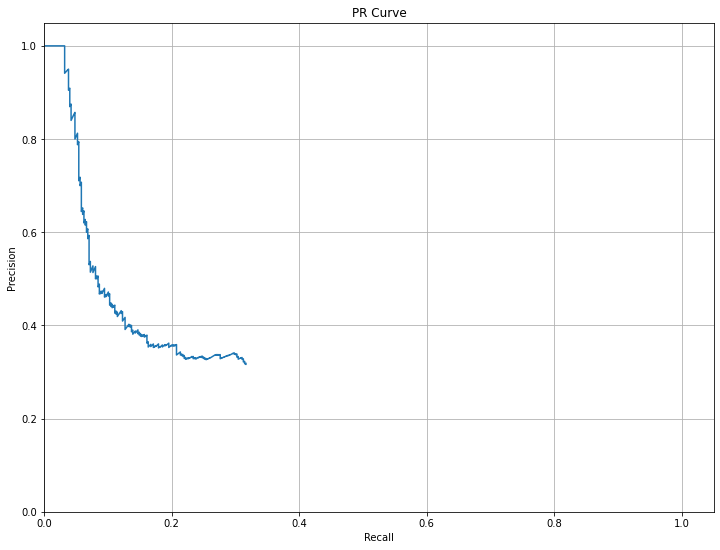

In [22]:
_ = plt.figure(figsize=(12, 9))
plt.plot(r, p)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve")
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.grid()